In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.autograd as autograd

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


## WGAN

In [11]:
latent_dim = 100
n_classes = 2


class WGGenerator(nn.Module):
    def __init__(self):
        super(WGGenerator, self).__init__()
        
        self.label_embed = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 64 * 64),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        inputs = torch.cat((self.label_embed(labels), noise), -1)
        img = self.model(inputs)
        img = img.view(img.size(0), 1, 64, 64)
        return img


class WGDiscriminator(nn.Module):
    def __init__(self):
        super(WGDiscriminator, self).__init__()
        
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(1 * 64 * 64 + n_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        flattened = img.view(img.size(0), -1)
        inputs = torch.cat((flattened, self.label_embed(labels)), -1)
        validity = self.model(inputs)
        
        return validity

In [12]:
# 생성자(generator)와 판별자(discriminator) 초기화
wg_generator = WGGenerator()
wg_discriminator = WGDiscriminator()

wg_generator.cuda()
wg_discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
#optimizer_G = torch.optim.RMSprop(wg_generator.parameters(), lr=0.00002)
#optimizer_D = torch.optim.RMSprop(wg_discriminator.parameters(), lr=0.00002)
optimizer_G = torch.optim.Adam(wg_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(wg_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [13]:
Tensor = torch.cuda.FloatTensor
LongTensor = torch.cuda.LongTensor

def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    """Calculates the gradient penalty loss for WGAN GP.
       Warning: It doesn't compute the gradient w.r.t the labels, only w.r.t
       the interpolated real and fake samples, as in the WGAN GP paper.
    """
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    labels = LongTensor(labels)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = Tensor(real_samples.shape[0], 1).fill_(1.0)
    # fake = torch.cuda.FloatTensor(real_samples.shape[0], 1).fill_(1.0)
    fake.requires_grad = False
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )
    gradients = gradients[0].view(gradients[0].size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [19]:
n_epochs = 30
sample_interval = 500
lambda_gp = 10
start_time = time.time()

for epoch in range(n_epochs):

    for i, (imgs, labels) in enumerate(train_dataloader):

        # Configure input
        real_imgs = imgs.cuda()
        labels = labels.cuda()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        # generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()
        
        # Generate a batch of images
        fake_imgs = wg_generator(z, labels)
        
        # Real images
        real_validity = wg_discriminator(real_imgs, labels)
        # Fake images
        fake_validity = wg_discriminator(fake_imgs, labels)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(
                            wg_discriminator, real_imgs.data, fake_imgs.data,
                            labels.data)
        
        # Adversarial loss
        loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        loss_D.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()

        # Train the generator every n_critic iterations
        if i % 5 == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = wg_generator(z, labels)
            
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = wg_discriminator(fake_imgs, labels)
            loss_G = -torch.mean(fake_validity)

            loss_G.backward()
            optimizer_G.step()

            '''
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, 200, batches_done % len(train_dataloader), len(train_dataloader), loss_D.item(), loss_G.item())
            )
            '''
        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = wg_generator(z, labels)
            save_image(generated_imgs, f"./results/wgan/{done}.png", nrow=8, normalize=True)
        #batches_done += 1
        
    print(f"[Epoch {epoch}/{n_epochs}] [loss_D: {loss_D.item():.6f}] [loss_G: {loss_G.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/30] [loss_D: -4.210129] [loss_G: -0.714049] [Elapsed time: 13.34s]
[Epoch 1/30] [loss_D: -4.635091] [loss_G: 1.920543] [Elapsed time: 26.29s]
[Epoch 2/30] [loss_D: -3.149899] [loss_G: 1.323211] [Elapsed time: 39.47s]
[Epoch 3/30] [loss_D: -3.925522] [loss_G: 1.927672] [Elapsed time: 52.48s]
[Epoch 4/30] [loss_D: -4.285423] [loss_G: 0.712128] [Elapsed time: 65.58s]
[Epoch 5/30] [loss_D: -2.629848] [loss_G: -3.136309] [Elapsed time: 78.94s]
[Epoch 6/30] [loss_D: -1.735401] [loss_G: -2.980194] [Elapsed time: 91.97s]
[Epoch 7/30] [loss_D: -4.022290] [loss_G: -0.534879] [Elapsed time: 105.08s]
[Epoch 8/30] [loss_D: -4.595689] [loss_G: 1.557543] [Elapsed time: 118.16s]
[Epoch 9/30] [loss_D: -2.043464] [loss_G: -4.332799] [Elapsed time: 131.30s]
[Epoch 10/30] [loss_D: -1.859062] [loss_G: 3.943013] [Elapsed time: 144.97s]
[Epoch 11/30] [loss_D: -3.115753] [loss_G: -1.614241] [Elapsed time: 158.10s]
[Epoch 12/30] [loss_D: -4.374799] [loss_G: 4.126795] [Elapsed time: 171.34s]
[Epoch 13/

In [20]:
# 모델 파라미터 저장
torch.save(wg_generator.state_dict(), "WGAN_Generator_for_Face_Mask.pt")
torch.save(wg_discriminator.state_dict(), "WGAN_Discriminator_for_Face_Mask.pt")
print("Model saved!")

Model saved!


In [21]:
# 생성자(generator) 초기화
wgan_generator = WGGenerator()
wgan_generator.cuda()
wgan_generator.load_state_dict(torch.load("WGAN_Generator_for_Face_Mask.pt"))
wgan_generator.eval()

WGGenerator(
  (label_embed): Embedding(2, 2)
  (model): Sequential(
    (0): Linear(in_features=102, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=4096, bias=True)
    (12): Tanh()
  )
)

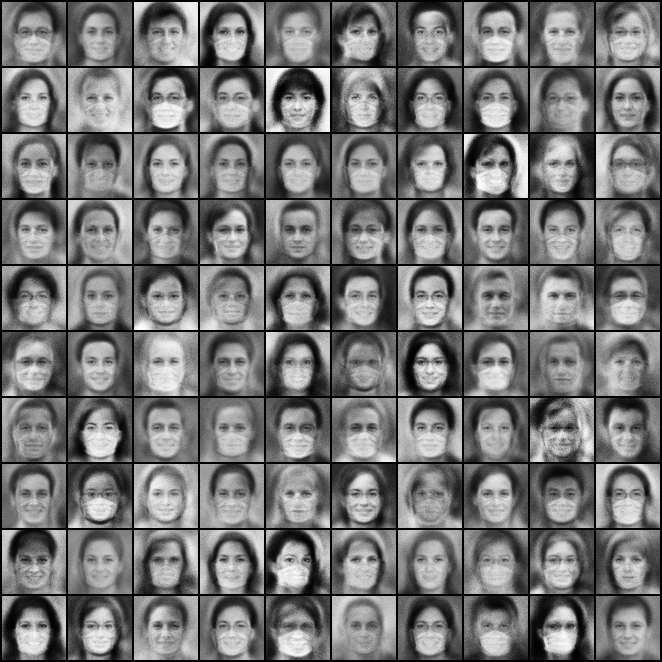

In [22]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(0)

# 이미지 생성
generated_imgs = wg_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/wgan/with_mask.png', nrow=10, normalize=True)

Display('./results/wgan/with_mask.png')

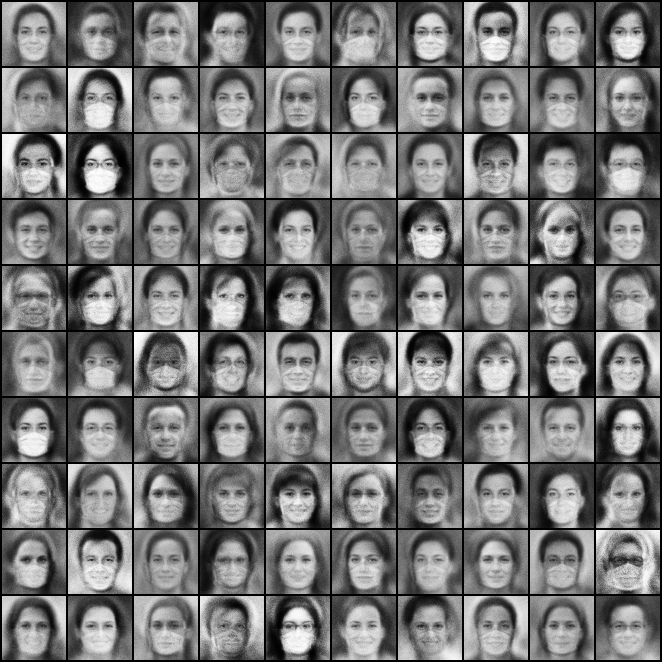

In [23]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(1)

# 이미지 생성
generated_imgs = wg_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/wgan/with_no_mask.png', nrow=10, normalize=True)

Display('./results/wgan/with_no_mask.png')